Epoch [1/10], Loss: 0.1350
Epoch [2/10], Loss: 0.0917
Epoch [3/10], Loss: 0.0936
Epoch [4/10], Loss: 0.0936
Epoch [5/10], Loss: 0.0936
Epoch [6/10], Loss: 0.0936
Epoch [7/10], Loss: 0.0936
Epoch [8/10], Loss: 0.0936
Epoch [9/10], Loss: 0.0936
Epoch [10/10], Loss: 0.0936
Model saved to blueprint_to_3d_model.pth


100%|██████████| 4/4 [00:06<00:00,  1.70s/it]



Test Results:
Loss: 0.0868, MSE: 0.0009, Accuracy: 99.90%


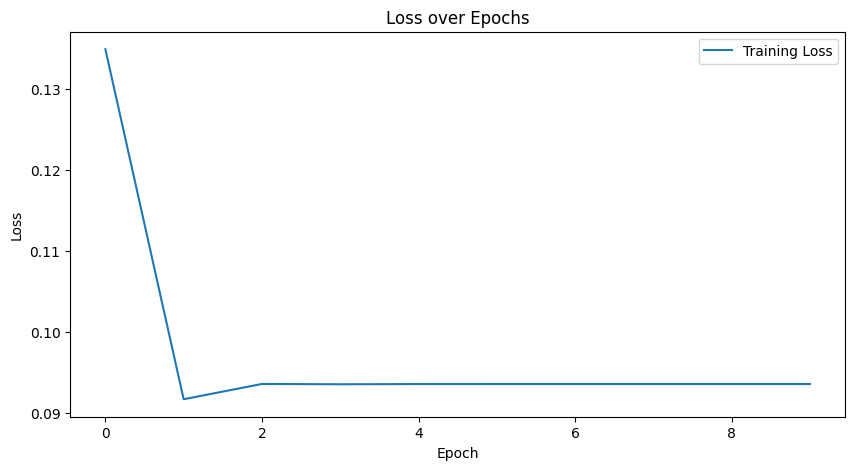

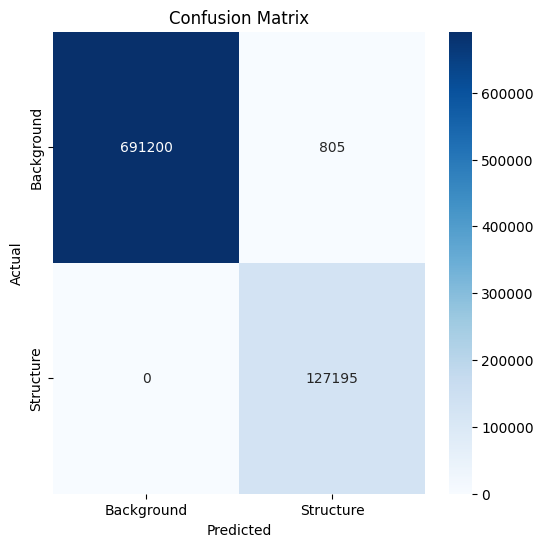

In [2]:
# Install required libraries
!pip install torch torchvision matplotlib pyvista scikit-learn seaborn --upgrade

# Import Libraries
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import pyvista as pv
from torchvision import transforms
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm import tqdm

# Define the Dataset
class FloorPlanDataset(Dataset):
    def __init__(self, image_dir, img_size=(64, 64), voxel_size=(32, 32, 32), transform=None):
        self.image_dir = image_dir
        self.image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir)]
        self.img_size = img_size
        self.voxel_size = voxel_size
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load blueprint image
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("L")  # Convert to grayscale
        image = image.resize(self.img_size, Image.Resampling.LANCZOS)  # Resize to fixed size
        image = np.array(image) / 255.0  # Normalize to [0, 1]
        
        # Convert to tensor (with channel dimension) and ensure float32 type
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # Shape: [1, H, W]
        
        # Remove channel dimension for voxel grid generation
        blueprint_2d = image.squeeze(0).numpy()  # Shape: [H, W]
        voxel_grid = self.generate_voxel_grid_from_blueprint(blueprint_2d)
        
        return image, torch.tensor(voxel_grid, dtype=torch.float32)

    @staticmethod
    def generate_voxel_grid_from_blueprint(blueprint, height=32):
        """
        Generate a 3D voxel grid from a 2D floor plan.
        Args:
            blueprint (np.ndarray): 2D binary image (H x W).
            height (int): Height of the 3D voxel grid.
        Returns:
            np.ndarray: 3D voxel grid (32 x 32 x 32).
        """
        h, w = blueprint.shape
        voxel_grid = np.zeros((h, w, height), dtype=np.float32)
        voxel_grid[:, :, :5] = np.expand_dims(blueprint, axis=-1)  # Extrude walls
        
        # Resize voxel grid to fixed size (32x32x32)
        voxel_grid = torch.nn.functional.interpolate(
            torch.tensor(voxel_grid, dtype=torch.float32).unsqueeze(0).unsqueeze(0),
            size=(32, 32, 32),
            mode="trilinear",
            align_corners=False
        ).squeeze().numpy()
        
        # Threshold to create binary voxel grid
        voxel_grid = (voxel_grid > 0.5).astype(np.float32)
        
        return voxel_grid

# Define the CNN Model
class BlueprintTo3DModel(nn.Module):
    def __init__(self):
        super(BlueprintTo3DModel, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(64 * 16 * 16, 4096),  # Adjust based on input size
            nn.ReLU(),
            nn.Linear(4096, 32 * 32 * 32),  # Output voxel grid size
            nn.Sigmoid()  # Ensure output values are between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x.view(-1, 32, 32, 32)  # Reshape to 3D voxel grid

# Training Loop with Loss Tracking
def train_model(model, dataloader, criterion, optimizer, num_epochs=10):
    model.train()
    loss_history = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for blueprints, voxels in dataloader:
            blueprints, voxels = blueprints.to(device), voxels.to(device)
            blueprints, voxels = blueprints.float(), voxels.float()

            # Forward pass
            outputs = model(blueprints)
            loss = criterion(outputs, voxels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        epoch_loss = running_loss / len(dataloader)
        loss_history.append(epoch_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
    
    return loss_history

# Testing Function with Metrics
def test_model(model, dataloader, threshold=0.5):
    model.eval()
    all_preds = []
    all_targets = []
    test_loss = 0.0
    mse_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for blueprints, voxels in tqdm(dataloader):
            blueprints, voxels = blueprints.to(device), voxels.to(device)
            outputs = model(blueprints)
            
            # Calculate loss
            loss = criterion(outputs, voxels)
            test_loss += loss.item()
            
            # Calculate MSE
            mse = F.mse_loss(outputs, voxels)
            mse_loss += mse.item()
            
            # Calculate accuracy
            preds = (outputs > threshold).float()
            correct += (preds == voxels).float().sum().item()
            total += voxels.numel()
            
            # Collect for confusion matrix
            all_preds.append(preds.view(-1).cpu().numpy())
            all_targets.append(voxels.view(-1).cpu().numpy())
    
    # Aggregate metrics
    test_loss /= len(dataloader)
    mse_loss /= len(dataloader)
    accuracy = correct / total
    
    # Confusion matrix
    cm = confusion_matrix(
        np.concatenate(all_targets),
        np.concatenate(all_preds)
    )
    
    return test_loss, mse_loss, accuracy, cm

# Visualization Functions
def plot_loss(loss_history):
    plt.figure(figsize=(10, 5))
    plt.plot(loss_history, label='Training Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_confusion_matrix(cm):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Background', 'Structure'],
                yticklabels=['Background', 'Structure'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def visualize_voxel_grid(voxel_grid):
    # Get dimensions of the voxel grid
    nx, ny, nz = voxel_grid.shape
    # Create coordinate arrays
    x = np.arange(nx)
    y = np.arange(ny)
    z = np.arange(nz)
    # Create a meshgrid
    X, Y, Z = np.meshgrid(x, y, z, indexing="ij")
    # Flatten the arrays and stack into point coordinates
    points = np.column_stack((X.ravel(), Y.ravel(), Z.ravel()))
    # Create a StructuredGrid
    grid = pv.StructuredGrid()
    grid.points = points
    grid.dimensions = [nx, ny, nz]
    # Set the voxel values
    grid["values"] = voxel_grid.flatten(order="F")
    grid.plot(cmap="viridis", show_edges=True)

# Sample Testing Function
def test_sample_image(model, image_path, device):
    # Preprocess image
    image = Image.open(image_path).convert("L")
    image = image.resize((64, 64), Image.Resampling.LANCZOS)
    image = np.array(image) / 255.0
    image = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    
    # Generate prediction
    model.eval()
    with torch.no_grad():
        output = model(image).cpu().numpy()[0]
    
    # Visualize
    visualize_voxel_grid(output)

# Main Script
if __name__ == "__main__":
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Hyperparameters
    batch_size = 8
    learning_rate = 0.001
    num_epochs = 10

    # Paths
    image_dir = "/kaggle/input/floor-plan-dataset/X"  # Update path to your dataset
    model_save_path = "blueprint_to_3d_model.pth"

    # Create dataset
    dataset = FloorPlanDataset(image_dir, img_size=(64, 64), voxel_size=(32, 32, 32))

    # Split dataset
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model, loss, and optimizer
    model = BlueprintTo3DModel().to(device)
    criterion = nn.BCELoss()  # Binary Cross Entropy Loss for voxel grids
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train model and get loss history
    loss_history = train_model(model, train_loader, criterion, optimizer, num_epochs=num_epochs)

    # Save the trained model
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

    # Evaluate on test set
    test_loss, mse, acc, cm = test_model(model, test_loader)
    print(f"\nTest Results:")
    print(f"Loss: {test_loss:.4f}, MSE: {mse:.4f}, Accuracy: {acc*100:.2f}%")
    
    # Plot results
    plot_loss(loss_history)
    plot_confusion_matrix(cm)
    
   